In [4]:
%matplotlib inline

import copy
import enum
import itertools
import math
import multiprocessing
import pathlib
import warnings

import matplotlib
import matplotlib.font_manager
import matplotlib.gridspec
import matplotlib.lines
import matplotlib.patches
import matplotlib.pyplot
import numpy
import scipy.stats
import sklearn.base
import sklearn.decomposition
import sklearn.ensemble
import sklearn.gaussian_process
import sklearn.gaussian_process.kernels
import sklearn.linear_model
import sklearn.manifold
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.svm
import sklearn.utils
import pandas
import xgboost

Fetch data

In [5]:
train = pandas.read_csv('contrib/processed_data/ADNI_Training_Q3_new.csv_matlab.csv', header=None)
first_seven_columns = [
    ('misc', 'mri_id'),
    ('features', 'age'),
    ('features', 'gender'),
    ('features', 'education'),
    ('features', 'apoe4'),
    ('targets', 'MMSE'),
    ('targets', 'diagnosis'),
]
train.columns = pandas.MultiIndex.from_tuples(
    first_seven_columns + 
    [('features', 'MRI{}'.format(j + 1)) for j in range(train.shape[1] - 7)]
)
del first_seven_columns

Label all MRI features

In [6]:
def update_mri_labels(train):
    sub_id = train.at[1, ('misc', 'mri_id')]
    train_map = pandas.read_csv('contrib/sample_basic_data/ADNI_Training_Q3_new.csv')
    dir_id = train_map.loc[train_map['Subject'] == sub_id, 'directory.id'].iat[0]

    path = pathlib.Path('contrib/sample_mri_data/training_image_tables') / dir_id / 'tables'
    label_map = pandas.read_csv(str(path / 'volumes_FreeSurfer_labels.csv'), index_col=1, usecols=[0, 1])['Label name']

    columns = list(train.columns)

    path = pathlib.Path('contrib/sample_mri_data/training_image_tables') / dir_id / 'tables'
    table = pandas.read_csv(str(path / 'thickinthehead_FreeSurfer_labels.csv'), index_col=0, usecols=[0, 3])
    for label, val in table.iterrows():
        val = val.iat[0]
        if val == 0:
            continue
        idx = numpy.where(abs(train.iloc[1, 7:] - val) == 0.0)[0]
        if not idx:
            continue
        columns[idx[0] + 7] = ('features', 'FreeSurferThickness|' + label)

    table = pandas.read_csv(str(path / 'volumes_FreeSurfer_labels.csv'), index_col=0, usecols=[0, 2])
    for label, val in table.iterrows():
        val = val.iat[0]
        if val == 0:
            continue
        idx = numpy.where(abs(train.iloc[1, 7:] - val) == 0.0)[0]
        if not idx:
            continue
        columns[idx[0] + 7] = ('features', 'FreeSurferVolume|' + label)

    table = pandas.read_csv('contrib/sample_mri_data/training_baseline_data.csv')
    table.set_index('Subject', inplace=True)
    table = table.loc[sub_id, :]
    for label, val in table.iteritems():
        try:
            val = float(val)
        except (TypeError, ValueError):
            continue
        if val == 0:
            continue
        idx = numpy.where(abs(train.iloc[1, 7:] - val) == 0.0)[0]
        if idx.size == 0:
            continue
        try:
            num = int(label[-4:])
        except:
            pass
        else:
            label = label[:-4] + '|' + label_map[num]
        columns[idx[0] + 7] = ('features', label)

    train.columns = pandas.MultiIndex.from_tuples(columns)

update_mri_labels(train)

/home/zhanghj/.local/opt/conda/envs/main/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2856: DtypeWarning: Columns (2162) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


MMSE evaluation metrics

In [7]:
def pearsonr(truth, pred):
    return scipy.stats.pearsonr(truth, pred)[0]


def linr(truth, pred):
    mean_truth = numpy.mean(truth)
    mean_pred = numpy.mean(pred)
    var_truth = numpy.var(truth)
    var_pred = numpy.var(pred)
    covar = numpy.cov([truth, pred])[0][1]
    return 2 * covar / (var_truth + var_pred + (mean_truth - mean_pred) ** 2)

Diagnosis evaluation metrics

In [8]:
class Diagnosis(enum.Enum):
    cn = 1
    mci = 2
    ad = 4


def f1_score(truth, pred):
    filter_ = truth != Diagnosis.mci.value
    return sklearn.metrics.f1_score(truth[filter_] == Diagnosis.ad.value, (pred < 26)[filter_], average='macro')


def auc(truth, pred):
    filter_ = truth != Diagnosis.mci.value
    return sklearn.metrics.roc_auc_score(truth[filter_] == Diagnosis.ad.value, -pred[filter_])


def _diagnose(mmse):
    return numpy.where(
        mmse > 28,
        Diagnosis.cn.value,
        numpy.where(
            mmse >= 26,
            Diagnosis.mci.value,
            Diagnosis.ad.value,
        ),
    )


def correct_ratio(truth, pred):
    return (truth == _diagnose(pred)).sum() / truth.size

Kernel

In [9]:
class CustomKernel(sklearn.gaussian_process.kernels.StationaryKernelMixin,
                   sklearn.gaussian_process.kernels.Kernel):
    _LEFT_HEMISPHERE_COLS = numpy.asarray([
        7, 9, 10, 15, 16, 23, # Areas (left)
        57, 58, 59, 60, 65, 66, 75, # Volumes (left)
    ])
    _HEMISPHERE_EXP_WEIGHTS = numpy.asarray([
        1/2000**2, 1/2000**2, 1/2000**2, 1/2000**2, 1/2000**2, 1/2000**2,
        1/4000**2, 1/4000**2, 1/4000**2, 1/4000**2, 1/4000**2, 1/4000**2, 1/4000**2,
    ])
    _HEMISPHERE_WEIGHTS = numpy.asarray([
        1/6, 1/6, 1/6, 1/6, 1/6, 1/6,
        4/7, 4/7, 4/7, 4/7, 4/7, 4/7, 4/7,
    ])

    def __init__(self, has_age=False, has_education=True, has_apoe=True, left_hemisphere=True, right_hemisphere=False,
                 noise=2.0):
        self.noise = noise
        self.has_age = has_age
        self.has_education = has_education
        self.has_apoe = has_apoe
        self.left_hemisphere = left_hemisphere
        self.right_hemisphere = right_hemisphere

    def __call__(self, X, Y=None, eval_gradient=False):
        cols = numpy.hstack((
            [0] if self.has_age else [],
            [2] if self.has_education else [],
            [3] if self.has_apoe else[],
            self._LEFT_HEMISPHERE_COLS if self.left_hemisphere else [],
            (self._LEFT_HEMISPHERE_COLS + 25) if self.right_hemisphere else [],
            [
                154, 155, # Hippocampus
                158, 159, # Inf lateral vent
                162, 163, # Amygdala
                177, 178, # Mean curvature mean
                241, 242, # Thickness mean
            ],
        )).astype('i2')
        exp_w = numpy.hstack((
            [1/16] if self.has_age else [],
            [1/2] if self.has_education else [],
            [1/2] if self.has_apoe else [],
            self._HEMISPHERE_EXP_WEIGHTS if self.left_hemisphere else [],
            self._HEMISPHERE_EXP_WEIGHTS if self.right_hemisphere else [],
            [
                1, 1,
                1, 1,
                1, 1,
                1, 1,
                1, 1,
            ],
        ))
        w = numpy.hstack((
            [1/2] if self.has_age else [],
            [1/2] if self.has_education else [],
            [1] if self.has_apoe else [],
            ((numpy.hstack((self._HEMISPHERE_WEIGHTS, self._HEMISPHERE_WEIGHTS)) / 2)
             if self.left_hemisphere and self.right_hemisphere else self._HEMISPHERE_WEIGHTS
             if self.left_hemisphere or self.right_hemisphere else []),
            [
                5/2, 5/2,
                1/2, 1/2,
                1/2, 1/2,
                1/10, 1/10,
                1/10, 1/10,
            ],
        ))
        if eval_gradient:
            raise ValueError(
                'This kernel does not support parameter optimisation.')
        if Y is None:
            Y = X
            mat = numpy.identity(X.shape[0]) * self.noise
        else:
            mat = 0
        dist = sklearn.metrics.pairwise.manhattan_distances(
            X[:, cols],
            Y[:, cols],
            sum_over_features=False
        )
        kernel = numpy.exp(-exp_w * dist ** 2)
        kernel *= w
        k = mat + kernel.sum(axis=1).reshape((X.shape[0], Y.shape[0]))
        return k

    def diag(self, X):
        w = numpy.hstack((
            [1/2] if self.has_age else [],
            [1/2] if self.has_education else [],
            [1] if self.has_apoe else [],
            ((numpy.hstack((self._HEMISPHERE_WEIGHTS, self._HEMISPHERE_WEIGHTS)) / 2)
             if self.left_hemisphere and self.right_hemisphere else self._HEMISPHERE_WEIGHTS
             if self.left_hemisphere or self.right_hemisphere else []),
            [
                5/2, 5/2,
                1/2, 1/2,
                1/2, 1/2,
                1/10, 1/10,
                1/10, 1/10,
            ],
        ))
        return numpy.diag(numpy.ones(X.shape[0]) * (w.sum() + self.noise))

    def is_stationary(self):
        return True

Preprocessing

In [10]:
def rescale(sources, targets=None):
    rescaler = sklearn.preprocessing.MinMaxScaler()
    sources[:, 154:253] = rescaler.fit_transform(sources[:, 154:253])
    if targets is not None:
        targets[:, 154:253] = rescaler.transform(targets[:, 154:253])


def standarise(sources, targets=None):
    rescaler = sklearn.preprocessing.StandardScaler()
    sources[:, 154:253] = rescaler.fit_transform(sources[:, 154:253])
    if targets is not None:
        targets[:, 154:253] = rescaler.transform(targets[:, 154:253])


def dummy(*args, **kargs):
    pass

Postprocessing

In [11]:
def renorm(x, y):
    return (y - y.mean()) / y.std(ddof=1) * x.std(ddof=1) + x.mean()

Plotting font

In [12]:
font = matplotlib.font_manager.FontProperties(fname='vendor/fonts/NimbusSansL-Regular.ttf')
font.set_size(7)
title_font = matplotlib.font_manager.FontProperties(fname='vendor/fonts/NimbusSansL-Regular.ttf')
title_font.set_size(12)

ADNI roster label

In [13]:
def update_longitudinal_data(train):
    train['misc', 'rid'] = train.misc.mri_id.str[-4:].astype('int')
    adni_mmse = pandas.read_csv('vendor/adni_labels/MMSE.csv')
    adni_mmse = adni_mmse[adni_mmse.Phase == 'ADNI1']
    adni_roster = pandas.read_csv('vendor/adni_labels/ROSTER.csv')
    adni_roster = adni_roster[adni_roster.Phase == 'ADNI1']
    adni_labels = pandas.read_csv('vendor/adni_labels/DXSUM_PDXCONV_ADNIALL.csv')
    adni_labels = adni_labels[adni_labels.Phase == 'ADNI1']
    adni_labels['DXCURREN'] = adni_labels.DXCURREN.where(adni_labels.DXCURREN != 3, 4)
    train['misc', 'site'] = 0
    sites = {}
    for __, row in train.iterrows():
        site = adni_roster[adni_roster.PTID == row.misc.mri_id].iloc[0].SITEID
        if site not in sites:
            sites[site] = len(sites) + 1
        train.at[__, ('misc', 'site')] = sites[site]
    followup = adni_labels[(adni_labels.RID.isin(train.misc.rid) & adni_labels.duplicated('RID'))].groupby('RID')['DXCURREN'].max()
    train['misc', 'conv'] = train.targets.diagnosis
    train.loc[(train.misc.conv == 2) & train.misc.rid.isin(followup[followup == 4].index), ('misc', 'conv')] = 3

update_longitudinal_data(train)

## Improving the diagnosis with multi-sectional data

Gaussian process methods are quite intuitive in comparison to many other complex machine learning models such as neural network, yet it is very effective in leveraging the information from multi-cohort medical records. Here we tracked the contributions of individual predictions. We identified changes regarding increasing number of training samples and compared the Gaussian process model against linear model. There are in total 34 cohorts present in our training dataset. On average, (number) of predictions were contributed from samples from different cohorts (Fig 5A). This can be validated through K-nearest neighbour analysis; on average, (number) of top 50 nearest neighbours are from different cohorts (Fig 5B). A diverse origin of contribution from different cohorts suggested the efficacy of our approach in dealing with multi-sectional datasets.

We then move on to test the benefit of multi-sectional data regarding growing datasets. One of the benefit of our model is its capability to improve its diagnosis accuracy with new data from different cohorts covering more outliner cases. This is not present in many well-studied models, performance of which would often be undermined by batch effects. In the above subtype analyses, we showed that quantitative results of many previous studies did not work well on a different cohort. We also specifically tracked how the prediction performance change regarding increasing number of samples from either the same cohort or different ones (Fig 5C--D). (...) Our approach unconventionally benefitted from multi-cohort datasets, allowing it to benefit further from large-scale multi-section studies.

Figure 5: contribution from cohorts to different diagnostic group,  K-NN cohort information, prediction with growing number of samples from same cohort, prediction with growing number of samples from different cohorts.



We then focus on early-onset patients. There are 48 subjects in our model that are younger than 65 years old, involving 4 normal, 30 MCI, and 14 AD subjects. We looked into their distribution in our datasets after the kernel transformation. In order to avoid information leak, we removed age data from our model to make this analysis fair. Among top 50 contributors of predictions for these subjects, (number) of them are early-onset patients. A linear discriminative analysis on early-onset and late-onset patients showed that these two groups of patients are linearly separable on the kernel similarity map. The separation between early-onset subjects and other AD patients in terms of MRI features was consistent with prior research on distinct early-onset subtypes. Further analysis showed that (...). In sum, the model was also sensitive enough to identify subtypes of AD that carry distinct pathological and phenotypical traits.

Figure 4: proportion of MCI-to-AD sample in MCI misdiangosis, early onset neighbour distributions, PCA on early onset sample against late onset samples

# Cross-validation

To skip the calculation and reload previously reproduced performance:

In [12]:
performance = pandas.read_csv('performance.csv', index_col=0)
performance.groupby(level='name').mean()

,acc,auc,f1,lin,pearson
name,,,,,
+APOE,0.547655,0.925673,0.845664,0.544488,0.542342
+APOE+Edu\n+Age,0.563800,0.931813,0.857486,0.600209,0.597847
0.01,0.523037,0.883723,0.814724,0.503536,0.501539
0.1,0.538800,0.905611,0.837688,0.547530,0.545359
1,0.546024,0.916767,0.852607,0.572870,0.570606
10,0.537095,0.913778,0.841360,0.568949,0.566709
100,0.511239,0.892239,0.803585,0.516493,0.514452
4,0.541030,0.916897,0.852453,0.575118,0.572851
Both hemisphere,0.536531,0.918081,0.843345,0.568910,0.566663


To reproduce the cross-validation and the bootstrap test

In [13]:
def validate(name, pipeline, cv_indices):
    preprocessor = pipeline[0]
    if isinstance(pipeline[1], sklearn.ensemble.GradientBoostingRegressor):
        predictor = sklearn.base.clone(pipeline[1])
    else:
        predictor = copy.deepcopy(pipeline[1])
    train_idx, test_idx = cv_indices
    train_x = copy.deepcopy(train.iloc[train_idx, :].loc[:, 'features'].values)
    test_x = copy.deepcopy(train.iloc[test_idx, :].loc[:, 'features'].values)
    train_y = copy.deepcopy(train.iloc[train_idx, :].loc[:, ('targets', 'MMSE')].values)
    test_y = copy.deepcopy(train.iloc[test_idx, :].loc[:, ('targets', 'MMSE')].values)
    label_y = copy.deepcopy(train.iloc[test_idx, :].loc[:, ('targets', 'diagnosis')].values)
    preprocessor(train_x, test_x)
    predictor.fit(train_x, train_y)
    pred_y = renorm(train_y, predictor.predict(test_x))
    return pandas.Series({
        'name': name,
        'pearson': pearsonr(test_y, pred_y),
        'lin': linr(test_y, pred_y),
        'f1': f1_score(label_y, pred_y),
        'acc': correct_ratio(label_y, pred_y),
        'auc': auc(label_y, pred_y),
    })


def parallel_cross_validate(pipelines, n_splits=5, n_repeats=5, n_jobs=2):
    warnings.simplefilter('ignore')
    kfold = sklearn.model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True)
    p = multiprocessing.Pool(n_jobs)
    performance = p.starmap(validate, [
        (name, pipeline, cv_indices)
        for __ in range(n_repeats)
        for cv_indices in kfold.split(train.values, train[('targets', 'diagnosis')].values)
        for name, pipeline in pipelines.items()
    ])
    performance = pandas.concat(performance, axis=1).T
    performance['pearson'] = performance['pearson'].astype('f4')
    performance['lin'] = performance['lin'].astype('f4')
    performance['f1'] = performance['f1'].astype('f4')
    performance['acc'] = performance['acc'].astype('f4')
    performance['auc'] = performance['auc'].astype('f4')
    performance.set_index('name', inplace=True)
    warnings.simplefilter('default')
    return performance


def bootstrap_split(n_sample, n_repeats):
    for __ in range(n_repeats):
        id_ = numpy.arange(n_sample)
        train = sklearn.utils.resample(id_)
        test = numpy.setdiff1d(id_, train)
        yield train, test


def parallel_bootstrap(pipelines, n_repeats=10, n_jobs=2):
    warnings.simplefilter('ignore')
    p = multiprocessing.Pool(n_jobs)
    performance = p.starmap(validate, [
        (name, pipeline, sample_indices)
        for sample_indices in bootstrap_split(len(train), n_repeats)
        for name, pipeline in pipelines.items()
    ])
    performance = pandas.concat(performance, axis=1).T
    performance['pearson'] = performance['pearson'].astype('f4')
    performance['lin'] = performance['lin'].astype('f4')
    performance['f1'] = performance['f1'].astype('f4')
    performance['acc'] = performance['acc'].astype('f4')
    performance['auc'] = performance['auc'].astype('f4')
    performance.set_index('name', inplace=True)
    warnings.simplefilter('default')
    return performance

In [14]:
performance = parallel_cross_validate(
    {
        'L': (rescale, sklearn.linear_model.LinearRegression()),
        'L1': (rescale, sklearn.linear_model.Lasso(max_iter=3000)),
        'L2': (rescale, sklearn.linear_model.Ridge(max_iter=3000)),
        'Final': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'RF': (rescale, sklearn.ensemble.RandomForestRegressor()),
        'GB': (rescale, sklearn.ensemble.GradientBoostingRegressor()),
        'SVR': (rescale, sklearn.svm.SVR(kernel=CustomKernel())),
        'LSVR': (rescale, sklearn.svm.LinearSVR()),
        'XGB': (rescale, xgboost.XGBRegressor()),
        '1': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=1.0), alpha=0)),
        '4': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=4.0), alpha=0)),
        '0.1': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=0.1), alpha=0)),
        '0.01': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=0.01), alpha=0)),
        '10': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=10), alpha=0)),
        '100': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=100), alpha=0)),
        'No scaler': (dummy, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'Standard': (standarise, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'Control': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_education=False, has_apoe=False), alpha=0)),
        '+APOE': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_education=False), alpha=0)),
        '+APOE+Edu\n+Age': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_age=True), alpha=0)),
        'Right only': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(left_hemisphere=False, right_hemisphere=True), alpha=0)),
        'Both hemisphere': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(left_hemisphere=True, right_hemisphere=True), alpha=0)),
    },
    n_jobs=3
)
performance.to_csv('performance.csv')
performance.groupby(level='name').mean()

,acc,auc,f1,lin,pearson
name,,,,,
+APOE,0.547655,0.925673,0.845664,0.544488,0.542342
+APOE+Edu\n+Age,0.563800,0.931813,0.857486,0.600209,0.597847
0.01,0.523037,0.883723,0.814724,0.503536,0.501539
0.1,0.538800,0.905611,0.837688,0.547530,0.545359
1,0.546024,0.916767,0.852607,0.572870,0.570606
10,0.537095,0.913778,0.841360,0.568949,0.566709
100,0.511239,0.892239,0.803585,0.516493,0.514452
4,0.541030,0.916897,0.852453,0.575118,0.572851
Both hemisphere,0.536531,0.918081,0.843345,0.568910,0.566663


In [59]:
bootperformance = parallel_bootstrap(
    {
        'L': (rescale, sklearn.linear_model.LinearRegression()),
        'L1': (rescale, sklearn.linear_model.Lasso(max_iter=3000)),
        'L2': (rescale, sklearn.linear_model.Ridge(max_iter=3000)),
        'Final': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'RF': (rescale, sklearn.ensemble.RandomForestRegressor()),
        'GB': (rescale, sklearn.ensemble.GradientBoostingRegressor()),
        'SVM': (rescale, sklearn.svm.SVR(kernel=CustomKernel())),
        'LSVM': (rescale, sklearn.svm.LinearSVR()),
        '1': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=1.0), alpha=0)),
        '4': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=4.0), alpha=0)),
        '0.1': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=0.1), alpha=0)),
        '0.01': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=0.01), alpha=0)),
        '10': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=10), alpha=0)),
        '100': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(noise=100), alpha=0)),
        'No scaler': (dummy, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'Standard': (standarise, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)),
        'Control': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_education=False, has_apoe=False), alpha=0)),
        '+APOE': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_education=False), alpha=0)),
        '+APOE+Edu\n+Age': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(has_age=True), alpha=0)),
        'Right only': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(left_hemisphere=False, right_hemisphere=True), alpha=0)),
        'Both hemisphere': (rescale, sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(left_hemisphere=True, right_hemisphere=True), alpha=0)),
    },
    n_repeats=100,
    n_jobs=3
)
bootperformance.to_csv('bootperformance.csv')
bootperformance.groupby(level='name').mean()

,acc,auc,f1,lin,pearson
name,,,,,
+APOE,0.530855,0.914923,0.830102,0.528152,0.528591
+APOE+Edu\n+Age,0.543885,0.922065,0.846420,0.580398,0.580878
0.01,0.490654,0.859075,0.784832,0.462481,0.462893
0.1,0.509766,0.887729,0.813562,0.513044,0.513485
1,0.525665,0.906273,0.836385,0.551674,0.552140
10,0.532745,0.909160,0.841098,0.563013,0.563480
100,0.512109,0.894912,0.807055,0.524923,0.525361
4,0.533063,0.910444,0.841612,0.563046,0.563517
Both hemisphere,0.525062,0.908668,0.835236,0.549869,0.550337


In [13]:
def confusion_matrix():
    preprocessor = rescale
    predictor = sklearn.gaussian_process.GaussianProcessRegressor(kernel=CustomKernel(), alpha=0)
    train_x = copy.deepcopy(train.loc[:, 'features'].values)
    test_x = copy.deepcopy(train.loc[:, 'features'].values)
    train_y = copy.deepcopy(train.loc[:, ('targets', 'MMSE')].values)
    label_y = copy.deepcopy(train.loc[:, ('targets', 'diagnosis')].values)
    preprocessor(train_x, test_x)
    predictor.fit(train_x, train_y)
    pred_y = renorm(train_y, predictor.predict(test_x))
    pred_label_y = _diagnose(pred_y)
    result = pandas.DataFrame({
        'truth': label_y,
        'prediction': pred_label_y,
        'count': 1,
    })
    #return result
    return pandas.pivot_table(result, values='count', index=['truth'], columns=['prediction'], aggfunc='sum')

confusion_matrix()

prediction,1,2,4
truth,,,
1,143,36,4
2,83,111,102
4,11,21,97


# Figures

Figure 1 icon

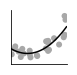

In [20]:
def target_line(x):
    return (x - 3) ** 2 / 10 + 2


def sample_point():
    xs = numpy.random.random(size=25) * 10
    ys = target_line(xs)
    ys += (numpy.random.random(size=25) - 0.5) * ys * 0.8
    return xs, ys


xs, ys = sample_point()
xlim = numpy.linspace(0, 10, 100)

fig = matplotlib.pyplot.figure(facecolor='white', linewidth=0, frameon=False, figsize=(1, 1))
grid = matplotlib.gridspec.GridSpec(1, 1)

ax = fig.add_subplot(grid[0, 0])
ax.set_ylim((0, 10))
ax.set_xlim((0, 10))
ax.get_yaxis().set_tick_params(right='off')
ax.get_xaxis().set_tick_params(top='off')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.scatter(xs, ys, edgecolor='None', c='#A8A8A8')
ax.plot(xlim, target_line(xlim), c='#000000')
ax.set_xticks([])
ax.set_yticks([])

fig.savefig('docs/images/1_icon.eps', dpi=900)
fig.savefig('docs/images/1_icon.png', dpi=100)
matplotlib.pyplot.show()

Figure 2 Cross-validation performance

/home/zhanghj/.local/opt/conda/envs/main/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


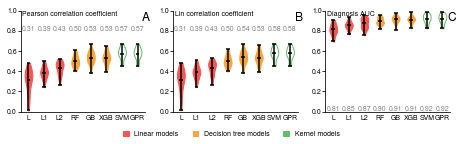

In [15]:
BAR_OFFSET = numpy.asarray([[1, 0], [-1, 0]])

metrics = [
    ('Pearson correlation coefficient', 'pearson'),
    ('Lin correlation coefficient', 'lin'),
    ('Diagnosis AUC', 'auc'),
]

fig = matplotlib.pyplot.figure(linewidth=0, frameon=False, figsize=(6.5, 2))
grid = matplotlib.gridspec.GridSpec(1, 3)
labels = 'ABC'

params = ['L', 'L1', 'L2', 'RF', 'GB', 'XGB', 'SVM', 'GPR']
for col, (label, (metric_name, metric_col)) in enumerate(zip(labels, metrics)):
    entry_count = len(params)
    ax = fig.add_subplot(grid[0, col])
    indices = numpy.arange(entry_count)
    ax.set_xlim((0, entry_count))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_tick_params(right='off')
    ax.get_xaxis().set_tick_params(top='off', bottom='off')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    entries = ax.violinplot(
        [performance.loc[p if p in performance.index else 'Final', metric_col] for p in params],
        indices + 0.5, showmeans=True, widths=(0.25 if entry_count < 5 else 0.5),
    )
    fmt = '{:.2f}'
    for i, (entry, p) in enumerate(zip(entries['bodies'], params)):
        if p in ['L', 'L1', 'L2']:
            color = '#F15854'
        elif p in ['RF', 'GB', 'XGB']:
            color = '#FAA43A'
        else:
            color = '#60BD68'
        entry.set_facecolor(color if p in performance.index else '#FFFFFF')
        entry.set_edgecolor(color)
        entry.set_alpha(1)
        ax.text(
            i + 0.5,
            0.8 if col < 2 else 0.01,
            fmt.format(performance.loc[p if p in performance.index else 'Final', metric_col].mean()),
            color='#808080',
            horizontalalignment='center',
            fontproperties=font,
        )
    for entry in ['cmeans', 'cmaxes', 'cmins']:
        entries[entry].set_edgecolor('black')
        for path in entries[entry].get_paths():
            path.vertices += BAR_OFFSET * 0.25
    entries['cbars'].set_edgecolor('black')
    ax.text(entry_count - 0.2, 0.9, label, color='black', fontproperties=title_font)
    ax.text(0.1, 0.95, metric_name, color='black', fontproperties=font)
    ax.set_xticks(indices + 0.5)
    ax.tick_params(axis='both', which='major', direction='out', pad=0.25)
    ax.set_xticklabels(params)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

l_patch = matplotlib.patches.Patch(color='#F15854', label='Linear models')
dt_patch = matplotlib.patches.Patch(color='#FAA43A', label='Decision tree models')
k_patch = matplotlib.patches.Patch(color='#60BD68', label='Kernel models')
fig.legend(
    handles=[l_patch, dt_patch, k_patch],
    labels=['Linear models', 'Decision tree models', 'Kernel models'],
    markerscale=0.5,
    frameon=False,
    handlelength=0.8,
    loc='lower center',
    prop=font,
    ncol=3,
)

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.savefig('docs/images/2.tiff', dpi=900)
fig.savefig('docs/images/2.png', dpi=300)
matplotlib.pyplot.show()

Supplementary Figure 1. Bootstrap performance

/home/zhanghj/.local/opt/conda/envs/main/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NameError: name 'bootperformance' is not defined

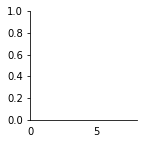

In [16]:
BAR_OFFSET = numpy.asarray([[1, 0], [-1, 0]])

metrics = [
    ('Pearson correlation coefficient', 'pearson'),
    ('Lin correlation coefficient', 'lin'),
    ('Diagnosis AUC', 'auc'),
]

fig = matplotlib.pyplot.figure(linewidth=0, frameon=False, figsize=(6.5, 2))
grid = matplotlib.gridspec.GridSpec(1, 3)
labels = 'ABC'

params = ['L', 'L1', 'L2', 'RF', 'GB', 'XGB', 'SVM', 'GPR']
for col, (label, (metric_name, metric_col)) in enumerate(zip(labels, metrics)):
    entry_count = len(params)
    ax = fig.add_subplot(grid[0, col])
    indices = numpy.arange(entry_count)
    ax.set_xlim((0, entry_count))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_tick_params(right='off')
    ax.get_xaxis().set_tick_params(top='off', bottom='off')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    entries = ax.violinplot(
        [bootperformance.loc[p if p in bootperformance.index else 'Final', metric_col] for p in params],
        indices + 0.5, showmeans=True, widths=(0.25 if entry_count < 5 else 0.5),
    )
    fmt = '{:.2f}'
    for i, (entry, p) in enumerate(zip(entries['bodies'], params)):
        if p in ['L', 'L1', 'L2']:
            color = '#F15854'
        elif p in ['RF', 'GB', 'XGB']:
            color = '#FAA43A'
        else:
            color = '#60BD68'
        entry.set_facecolor(color if p in bootperformance.index else '#FFFFFF')
        entry.set_edgecolor(color)
        entry.set_alpha(1)
        ax.text(
            i + 0.5,
            0.8 if col < 2 else 0.01,
            fmt.format(bootperformance.loc[p if p in bootperformance.index else 'Final', metric_col].mean()),
            color='#808080',
            horizontalalignment='center',
            fontproperties=font,
        )
    for entry in ['cmeans', 'cmaxes', 'cmins']:
        entries[entry].set_edgecolor('black')
        for path in entries[entry].get_paths():
            path.vertices += BAR_OFFSET * 0.25
    entries['cbars'].set_edgecolor('black')
    ax.text(entry_count - 0.2, 0.9, label, color='black', fontproperties=title_font)
    ax.text(0.1, 0.95, metric_name, color='black', fontproperties=font)
    ax.set_xticks(indices + 0.5)
    ax.tick_params(axis='both', which='major', direction='out', pad=0.25)
    ax.set_xticklabels(params)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

l_patch = matplotlib.patches.Patch(color='#F15854', label='Linear models')
dt_patch = matplotlib.patches.Patch(color='#FAA43A', label='Decision tree models')
k_patch = matplotlib.patches.Patch(color='#60BD68', label='Kernel models')
fig.legend(
    handles=[l_patch, dt_patch, k_patch],
    labels=['Linear models', 'Decision tree models', 'Kernel models'],
    markerscale=0.5,
    frameon=False,
    handlelength=0.8,
    loc='lower center',
    prop=font,
    ncol=3,
)

fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.savefig('docs/images/SBoot.tiff', dpi=900)
fig.savefig('docs/images/SBoot.png', dpi=300)
matplotlib.pyplot.show()

Supplementary 2: Cross-validation performance of parameters

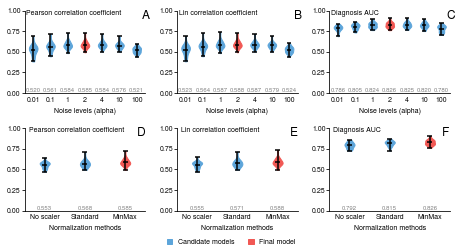

In [276]:
BAR_OFFSET = numpy.asarray([[1, 0], [-1, 0]])

metrics = [
    ('Pearson correlation coefficient', 'pearson'),
    ('Lin correlation coefficient', 'lin'),
    ('Diagnosis AUC', 'auc'),
]

parameters = [
    ('Noise levels (alpha)', ['0.01', '0.1', '1', '2', '4', '10', '100']),
    ('Normalization methods', ['No scaler', 'Standard', 'MinMax']),
]

fig = matplotlib.pyplot.figure(linewidth=0, frameon=False, figsize=(6.5, 3.5))
grid = matplotlib.gridspec.GridSpec(2, 3)
labels = 'ADBECF'

for label, ((row, (metric_name, metric_col)), (col, (param_name, params))) in zip(
    labels, itertools.product(enumerate(metrics), enumerate(parameters))
):
    entry_count = len(params)
    ax = fig.add_subplot(grid[col, row])
    indices = numpy.arange(entry_count)
    ax.set_xlim((0, entry_count))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_tick_params(right='off')
    ax.get_xaxis().set_tick_params(top='off', bottom='off')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    entries = ax.violinplot(
        [performance.loc[p if p in performance.index else 'Final', metric_col] for p in params],
        indices + 0.5, showmeans=True, widths=(0.25 if entry_count < 5 else 0.5),
    )
    fmt = '{:.2f}' if entry_count > 7 else '{:.3f}'
    for j, (entry, p) in enumerate(zip(entries['bodies'], params)):
        entry.set_facecolor('#5DA5DA' if p in performance.index else '#F15854')
        entry.set_edgecolor('#5DA5DA' if p in performance.index else '#F15854')
        entry.set_alpha(1)
        ax.text(
            j + 0.5,
            0.01,
            fmt.format(performance.loc[p if p in performance.index else 'Final', metric_col].mean()),
            color='#808080',
            horizontalalignment='center',
            fontproperties=font,
            size=6,
        )
    for entry in ['cmeans', 'cmaxes', 'cmins']:
        entries[entry].set_edgecolor('black')
        for path in entries[entry].get_paths():
            path.vertices += BAR_OFFSET * (0.125 if entry_count < 5 else 0.25)
    entries['cbars'].set_edgecolor('black')
    ax.text(entry_count - 0.2, 0.9, label, color='black', fontproperties=title_font)
    ax.text(0.1, 0.95, metric_name, color='black', fontproperties=font)
    ax.set_xticks(indices + 0.5)
    ax.tick_params(axis='both', which='major', direction='out', pad=0.25)
    ax.set_xticklabels(params)
    ax.set_xlabel(param_name, fontproperties=font)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        
cand_patch = matplotlib.patches.Patch(color='#5DA5DA', label='Candidate models')
final_patch = matplotlib.patches.Patch(color='#F15854', label='Final model')
fig.legend(
    handles=[cand_patch, final_patch],
    labels=['Candidate models', 'Final model'],
    markerscale=0.5,
    frameon=False,
    handlelength=0.8,
    loc='lower center',
    prop=font,
    ncol=2,
)
fig.tight_layout()
fig.subplots_adjust(bottom=0.15)
fig.savefig('docs/images/S1.tiff', dpi=900)
fig.savefig('docs/images/S1.png', dpi=300)
matplotlib.pyplot.show()

Figure 3. PCA of the similarity matrices

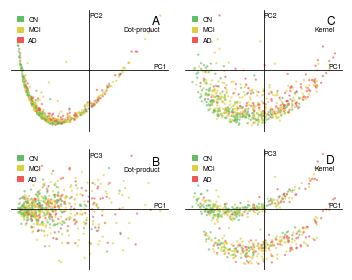

In [435]:
fig = matplotlib.pyplot.figure(facecolor='white', linewidth=0, frameon=False, figsize=(5, 4))
gs = matplotlib.gridspec.GridSpec(2, 2)
color_map = pandas.Series(
    ['#60BD68', '#DECF3F', '#F15854'],
    index=[x.value for x in Diagnosis],
)
colors = train['targets', 'diagnosis'].map(color_map).values
labels = 'ABCD'

for i in range(2):
    for j in range(2):
        ax = fig.add_subplot(gs[j, i])
        if i == 0:
            points = numpy.corrcoef(train.loc[:, 'features'].values.astype('f4'))
        else:
            kernel = CustomKernel(noise=0)
            points = kernel(train.loc[:, 'features'].values.astype('f4'))
        pca = sklearn.decomposition.PCA(3)
        mapped = pca.fit_transform(points)
        ax.scatter(mapped[:, 0], mapped[:, j + 1], c=colors, s=2, alpha=0.5)
        cn_patch = matplotlib.patches.Patch(color='#60BD68', label='CN')
        mci_patch = matplotlib.patches.Patch(color='#DECF3F', label='MCI')
        ad_patch = matplotlib.patches.Patch(color='#F15854', label='AD')
        leg = ax.legend(
            handles=[cn_patch, mci_patch, ad_patch],
            labels=['CN', 'MCI', 'AD'],
            markerscale=0.5,
            frameon=False,
            handlelength=0.8,
            loc='upper left',
            prop=font,
            #ncol=3
        )
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.text(
            mapped[:, 0].max(),
            mapped[:, j + 1].max(),
            labels[i * 2 + j],
            verticalalignment='top',
            horizontalalignment='right',
            fontproperties=title_font,
        )
        ax.text(
            mapped[:, 0].max(),
            (mapped[:, j + 1].max() - mapped[:, j + 1].min()) * 0.9 + mapped[:, j + 1].min(),
            'Dot-product' if i == 0 else 'Kernel',
            verticalalignment='top',
            horizontalalignment='right',
            fontproperties=font,
        )
        ax.text(
            mapped[:, 0].max(),
            (mapped[:, j + 1].max() - mapped[:, j + 1].min()) * 0.5 + mapped[:, j + 1].min(),
            'PC1',
            verticalalignment='bottom',
            horizontalalignment='center',
            fontproperties=font,
        )
        ax.text(
            (mapped[:, 0].max() - mapped[:, 0].min()) * 0.5 + mapped[:, 0].min(),
            mapped[:, j + 1].max(),
            f'PC{j + 2}',
            verticalalignment='center',
            horizontalalignment='left',
            fontproperties=font,
        )

fig.tight_layout()
fig.savefig('docs/images/3.tif', dpi=900)
fig.savefig('docs/images/3.png', dpi=300)
matplotlib.pyplot.show()

Supplementary Figure 3. Similarity correlation score

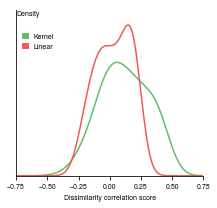

In [269]:
fig = matplotlib.pyplot.figure(facecolor='white', linewidth=0, frameon=False, figsize=(3, 3))
gs = matplotlib.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
X = numpy.linspace(-1, 1, 201)
kernel = CustomKernel(noise=0)
dist = kernel(train.loc[:, 'features'].values.astype('f4'))
diff = numpy.abs(train.targets.MMSE.values[:, None] - train.targets.MMSE.values)
corr1 = []
for j in range(dist.shape[0]):
    dist_row = numpy.delete(dist[j, :], j)
    diff_row = numpy.delete(diff[j, :], j)
    corr1.append(numpy.corrcoef(1 / dist_row, diff_row)[0, 1])
ax.plot(X, scipy.stats.gaussian_kde(corr1, bw_method=0.5).pdf(X), color='#60BD68')
dist = numpy.corrcoef(train.loc[:, 'features'].values.astype('f4'))
diff = numpy.abs(train.targets.MMSE.values[:, None] - train.targets.MMSE.values)
corr2 = []
for j in range(dist.shape[0]):
    dist_row = numpy.delete(dist[j, :], j)
    diff_row = numpy.delete(diff[j, :], j)
    corr2.append(numpy.corrcoef(1 / dist_row, diff_row)[0, 1])
ax.plot(X, scipy.stats.gaussian_kde(corr2, bw_method=0.5).pdf(X), color='#F15854')
max_y = scipy.stats.gaussian_kde(corr2, bw_method=0.5).pdf(X).max() * 1.1
ax.set_ylim((0, max_y))
ax.set_xlim((-0.75, 0.75))
ax.set_yticks([])
for lbl in ax.get_xticklabels():
    lbl.set_fontproperties(font)
ax.text(
    -0.75, max_y, 'Density',
    verticalalignment='top',
    horizontalalignment='left',
    fontproperties=font,
)
ax.set_xlabel('Dissimilarity correlation score', fontproperties=font)
cn_patch = matplotlib.patches.Patch(color='#60BD68', label='Kernel')
ad_patch = matplotlib.patches.Patch(color='#F15854', label='Linear')
leg = ax.legend(
    handles=[cn_patch, ad_patch],
    labels=['Kernel', 'Linear'],
    markerscale=0.5,
    frameon=False,
    handlelength=0.8,
    loc='upper left',
    bbox_to_anchor=(0, 0.9),
    prop=font,
)
fig.tight_layout()
fig.savefig('docs/images/S2.tif', dpi=900)
fig.savefig('docs/images/S2.png', dpi=300)
matplotlib.pyplot.show()

Figure 4. Similarity network

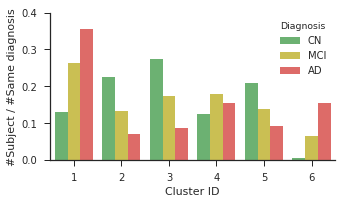

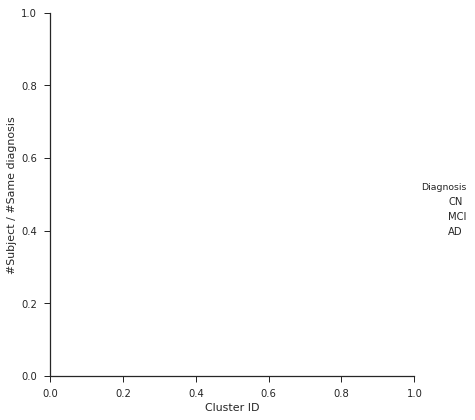

In [77]:
import seaborn as sns

cluster = pandas.read_csv('network/975clusters.csv').set_index('name')['__glayCluster']
cluster.name = ('misc', 'cluster')
cluster = train.join(cluster)
data = pandas.pivot_table(cluster, values=[('misc', 'mri_id')], index=[('misc', 'cluster')], columns=[('targets', 'diagnosis')], aggfunc='count')[:6]
data.index = [1, 2, 3, 4, 5, 6]
data.index.name = 'Cluster ID'
data.columns = ['CN', 'MCI', 'AD']
data.columns.name = 'Diagnosis'
sumdata = pandas.pivot_table(cluster, values=[('misc', 'mri_id')], index=[('misc', 'site')], columns=[('targets', 'diagnosis')], aggfunc='count').sum(axis=0)
sumdata.index = ['CN', 'MCI', 'AD']
sumdata.index.name = 'Diagnosis'
data = data / sumdata.T
data = data.unstack()
data.name = '#Subject / #Same diagnosis'
data = data.reset_index()
sns.set(style="ticks")
sns.set_palette(['#60BD68', '#DECF3F', '#F15854'])
# Draw a nested barplot to show survival for class and sex
fig = matplotlib.pyplot.figure(figsize=(5, 3))
gs = matplotlib.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4])
ax.set_ylim((0, 0.4))
sns.factorplot(x='Cluster ID', y='#Subject / #Same diagnosis', hue='Diagnosis', data=data,
               size=6, kind="bar", ax=ax)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
fig.savefig('new_cluster.png', dpi=900)

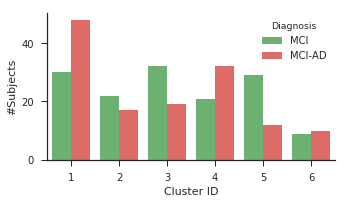

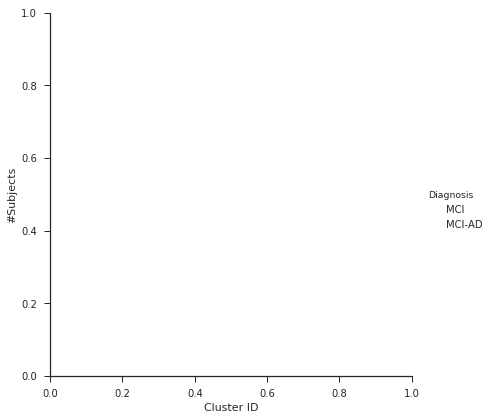

In [78]:
import seaborn as sns

cluster = pandas.read_csv('network/975clusters.csv').set_index('name')['__glayCluster']
cluster.name = ('misc', 'cluster')
cluster = train.join(cluster)
data = pandas.pivot_table(cluster, values=[('misc', 'mri_id')], index=[('misc', 'cluster')], columns=[('misc', 'conv')], aggfunc='count')[:6]
data.index = [1, 2, 3, 4, 5, 6]
data.index.name = 'Cluster ID'
data.columns = ['CN', 'MCI', 'MCI-AD', 'AD']
data.columns.name = 'Diagnosis'
data = data[['MCI', 'MCI-AD']]
data = data.unstack()
data.name = '#Subjects'
data = data.reset_index()
sns.set(style="ticks")
sns.set_palette(['#60BD68', '#F15854'])
# Draw a nested barplot to show survival for class and sex
fig = matplotlib.pyplot.figure(figsize=(5, 3))
gs = matplotlib.gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.set_yticks([0, 20, 40, 60, 80])
sns.factorplot(x='Cluster ID', y='#Subjects', hue='Diagnosis', data=data,
               size=6, kind="bar", ax=ax)
sns.despine(ax=ax, top=True, right=True)
fig.tight_layout()
fig.savefig('new_cluster2.png', dpi=900)

Supplementary Table 2. Network prediction performance

In [91]:
cluster = pandas.read_csv('network/975clusters.csv').set_index('name')['__glayCluster']
ad_network_id = cluster[cluster.isin([1, 4, 6])].index.values
cn_network_id = cluster[cluster.isin([2, 3, 5])].index.values

AD vs CN

In [92]:
group1 = numpy.unique(train.loc[ad_network_id, ('targets', 'diagnosis')].values, return_counts=True)[1]
group2 = numpy.unique(train.loc[cn_network_id, ('targets', 'diagnosis')].values, return_counts=True)[1]

scipy.stats.fisher_exact(numpy.vstack([group1, group2])[:, [0, 2]])

(0.13845321795565171, 7.1481580152316531e-15)

MCI vs MCI-AD

In [93]:
group1 = train.loc[ad_network_id]
group1 = numpy.unique(group1.loc[group1.targets.diagnosis == 2, ('misc', 'conv')].values, return_counts=True)[1]
group2 = train.loc[cn_network_id]
group2 = numpy.unique(group2.loc[group2.targets.diagnosis == 2, ('misc', 'conv')].values, return_counts=True)[1]

scipy.stats.fisher_exact(numpy.vstack([group1, group2]))

(0.38554216867469882, 0.00012284062053797716)

# Tables

Table 1

In [ ]:
from sklearn.cross_validation import StratifiedKFold

from gaussian_process import GaussianProcessRegressor


final_reg = GaussianProcessRegressor(kernel=CustomKernel())


def validate(args):
    targets, strata, features, training_indices, testing_indices = args
    training_targets = copy.deepcopy(targets[training_indices])
    testing_targets = copy.deepcopy(targets[testing_indices])
    training_features = copy.deepcopy(features[training_indices])
    testing_features = copy.deepcopy(features[testing_indices])
    rescale(training_features, testing_features)
    final_reg.fit(training_features, training_targets)
    testing_prediction = renorm(training_targets, final_reg.predict(testing_features))
    label_prediction = predict_label(testing_prediction)
    perf = []
    for t in [1, 2, 4]:
        idx = (strata[testing_indices] == t)
        pearson, _ = scipy.stats.pearsonr(testing_targets[idx], testing_prediction[idx])
        lin = lincorr(testing_targets[idx], testing_prediction[idx])
        ratio = (label_prediction[idx] == strata[testing_indices][idx]).sum() / idx.sum()
        perf.append((pearson, lin, ratio))
    return perf


def parallel_cross_validate(targets, strata, features, n_folds=5):
    validate_args = list()
    for x in range(5):
        kfold = StratifiedKFold(strata, n_folds=n_folds, shuffle=True)
        for training_indices, testing_indices in kfold:
            validate_args.append(
                (targets, strata, features, training_indices,
                 testing_indices),
            )
    p = Pool(2)
    perf = numpy.asarray(p.map(validate, validate_args))
    p.close()
    p.join()
    return perf


filename = 'ADNI_Training_Q3_new.csv_matlab.csv'
_, targets, strata, features = get_training_data(filename)
perf = parallel_cross_validate(targets, strata, features)
perf.mean(axis=0)[::-1, :], perf.std(axis=0, ddof=1)[::-1, :]

Table 3

In [ ]:
import math

import scipy.stats
import pandas
import IPython.display

filename = 'ADNI_Training_Q3_new.csv_matlab.csv'
_, targets, strata, features = get_training_data(filename)
rescale(features, features)
importance = pandas.DataFrame({}, dtype='f4')
importance['ANOVA F'] = [
    scipy.stats.f_oneway(features[strata==1, j], features[strata==2, j], features[strata==4, j])[0]
    for j in range(4, features.shape[1])
]
importance['ANOVA p'] = [
    scipy.stats.f_oneway(features[strata==1, j], features[strata==2, j], features[strata==4, j])[1]
    for j in range(4, features.shape[1])
]
importance['correlation'] = [
    abs(scipy.stats.pearsonr(targets, features[:, j])[0])
    for j in range(4, features.shape[1])
]
importance['ANOVA rank'] = len(importance) - importance['ANOVA F'].argsort().argsort()
importance['correlation rank'] = len(importance) - importance['correlation'].argsort().argsort()
importance['rank'] = (importance['ANOVA rank'] + importance['correlation rank'])
importance['variance'] = [
    math.sqrt(abs(numpy.cov(features[:, j], targets)[0, 1]))
    for j in range(4, features.shape[1])
]
importance.index = importance.index.values + 4
importance.sort_values('rank').loc[[
        #7, 9, 10, 15, 16, 23, # Areas (left)
        #57, 58, 59, 60, 65, 66, 75, # Volumes (left)
        154, 155, # Hippocampus
        158, 159, # Inf lateral vent
        162, 163, # Amygdala
        177, 178, # Mean curvature mean
        241, 242, # Thickness mean
    ], :]

# Supporting Information

Supplement Figure 1

In [ ]:
import itertools

BAR_OFFSET = numpy.asarray([[1, 0], [-1, 0]])

metric_name, metric_col = 'Diagnosis F1 score', 'f1'
parameters = [
    ('Regression algorithms', ['LSVM', 'L', 'L1', 'L2', 'GB', 'RF', 'SVM', 'GPR']),
    ('Noise levels (alpha)', ['0.01', '0.1', '1', '2', '4', '10', '100']),
    ('Normalization methods', ['No scaler', 'Standard', 'MinMax']),
]

fig = matplotlib.pyplot.figure(linewidth=0, frameon=False, figsize=(6.5, 2))
grid = matplotlib.gridspec.GridSpec(1, 3)
labels = 'ABC'

row = 0
for col, (label, (param_name, params)) in enumerate(zip(labels, parameters)):
    entry_count = len(params)
    ax = fig.add_subplot(grid[row, col])
    indices = numpy.arange(entry_count)
    ax.set_xlim((0, entry_count))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_tick_params(right='off')
    ax.get_xaxis().set_tick_params(top='off', bottom='off')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    entries = ax.violinplot(
        [performance.loc[p if p in performance.index else 'Final', metric_col] for p in params],
        indices + 0.5, showmeans=True, widths=(0.25 if entry_count < 5 else 0.5),
    )
    fmt = '{:.2f}' if entry_count > 7 else '{:.3f}'
    for j, (entry, p) in enumerate(zip(entries['bodies'], params)):
        entry.set_facecolor('#5DA5DA' if p in performance.index else '#F17CB0')
        entry.set_edgecolor('#0000FF' if p in performance.index else '#FF0000')
        entry.set_alpha(1)
        ax.text(
            j + 0.5,
            0.01,
            fmt.format(performance.loc[p if p in performance.index else 'Final', metric_col].mean()),
            color='#808080',
            horizontalalignment='center',
            fontproperties=font,
            size=6,
        )
    for entry in ['cmeans', 'cmaxes', 'cmins']:
        entries[entry].set_edgecolor('black')
        for path in entries[entry].get_paths():
            path.vertices += BAR_OFFSET * (0.125 if entry_count < 5 else 0.25)
    entries['cbars'].set_edgecolor('black')
    ax.text(entry_count - 0.2, 0.9, label, color='black', fontproperties=font, size=10)
    ax.text(0.1, 0.95, metric_name, color='black', fontproperties=font, size=6)
    ax.set_xticks(indices + 0.5)
    ax.tick_params(axis='both', which='major')
    ax.set_xticklabels(params)
    ax.set_xlabel(param_name, fontproperties=font, size=6)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        label.set_size(6)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        label.set_size(6)


fig.tight_layout()
fig.savefig('images/models_f1.eps', dpi=900)
fig.savefig('images/models_f1.pdf', dpi=900)
fig.savefig('images/models_f1.png', dpi=300)
matplotlib.pyplot.show()

Supplement Figure 2

In [ ]:
import itertools

BAR_OFFSET = numpy.asarray([[1, 0], [-1, 0]])

param_name = 'Clinical features'
params = ['Control', '+APOE', '+APOE+Edu', '+APOE+Edu\n+Age']

metrics = [
    ('Pearson correlation coefficient', 'pearson'),
    ('Lin correlation coefficient', 'lin'),
    ('Diagnosis AUC', 'auc'),
    ('Diagnosis F1 score', 'f1'),
]

fig = matplotlib.pyplot.figure(linewidth=0, frameon=False, figsize=(6.5, 5))
grid = matplotlib.gridspec.GridSpec(2, 2)
labels = 'ABCD'

for idx, (label, (metric_name, metric_col)) in enumerate(zip(labels, metrics)):
    row, col = divmod(idx, 2)
    entry_count = len(params)
    ax = fig.add_subplot(grid[row, col])
    indices = numpy.arange(entry_count)
    ax.set_xlim((0, entry_count))
    ax.set_ylim((0, 1))
    ax.get_yaxis().set_tick_params(right='off')
    ax.get_xaxis().set_tick_params(top='off', bottom='off')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    entries = ax.violinplot(
        [performance.loc[p if p in performance.index else 'Final', metric_col] for p in params],
        indices + 0.5, showmeans=True, widths=(0.25 if entry_count < 5 else 0.5),
    )
    fmt = '{:.2f}' if entry_count > 7 else '{:.3f}'
    for j, (entry, p) in enumerate(zip(entries['bodies'], params)):
        entry.set_facecolor('#5DA5DA' if p in performance.index else '#F17CB0')
        entry.set_edgecolor('#0000FF' if p in performance.index else '#FF0000')
        entry.set_alpha(1)
        ax.text(
            j + 0.5,
            0.01,
            fmt.format(performance.loc[p if p in performance.index else 'Final', metric_col].mean()),
            color='#808080',
            horizontalalignment='center',
            fontproperties=font,
            size=6,
        )
    for entry in ['cmeans', 'cmaxes', 'cmins']:
        entries[entry].set_edgecolor('black')
        for path in entries[entry].get_paths():
            path.vertices += BAR_OFFSET * (0.125 if entry_count < 5 else 0.25)
    entries['cbars'].set_edgecolor('black')
    ax.text(entry_count - 0.2, 0.9, label, color='black', fontproperties=font, size=10)
    ax.text(0.1, 0.95, metric_name, color='black', fontproperties=font, size=6)
    ax.set_xticks(indices + 0.5)
    ax.tick_params(axis='both', which='major')
    ax.set_xticklabels(params)
    ax.set_xlabel(param_name, fontproperties=font, size=6)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
        label.set_size(6)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)
        label.set_size(6)


fig.tight_layout()
fig.savefig('images/clinical.eps', dpi=900)
fig.savefig('images/clinical.pdf', dpi=900)
fig.savefig('images/clinical.png', dpi=300)
matplotlib.pyplot.show()

Supplement Table 1

In [ ]:
mri_features = train.iloc[:, 7:].values
cn_filter = (train['targets', 'diagnosis'] == Diagnosis.cn.value).values
mci_filter = (train['targets', 'diagnosis'] == Diagnosis.mci.value).values
ad_filter = (train['targets', 'diagnosis'] == Diagnosis.ad.value).values
f_test = scipy.stats.f_oneway(mri_features[cn_filter, :], mri_features[mci_filter, :], mri_features[ad_filter, :])
pearson = numpy.asarray([
    scipy.stats.pearsonr(mri_features[:, j], train['targets', 'MMSE'].values)[0]
    for j in range(mri_features.shape[1])
])
final = pandas.DataFrame({'ANOVA score': f_test[0], 'Pearson': numpy.abs(pearson)}, index=train.iloc[:, 7:].columns.get_level_values(1))
final.drop(['MRI168', 'MRI169'], axis=0, inplace=True)
final['ANOVA rank'] = final['ANOVA score'].rank(method='min', ascending=False).astype(int)
final['Pearson rank'] = final['Pearson'].rank(method='min', ascending=False).astype(int)

pandas.set_option('display.max_rows', 300)
IPython.display.display(final)
pandas.reset_option('display.max_rows')
final.to_clipboard()

## Network threshold

In [26]:
kernel = CustomKernel()(train.features.values)
kernel /= kernel.max()
kernel = pandas.DataFrame(kernel).unstack().reset_index()
kernel.columns = ['patient0', 'patient1', 'similarity']
kernel['diagnosis0'] = train.targets.diagnosis.iloc[kernel['patient0'].values].values
kernel['diagnosis1'] = train.targets.diagnosis.iloc[kernel['patient1'].values].values
kernel = kernel[(kernel.similarity != 1.0) & (kernel.patient0 < kernel.patient1)]
kernel.sort_values('similarity', inplace=True)
kernel.to_csv('network/complete/original.csv', index=False)

In [27]:
for threshold in [0.995, 0.99, 0.975, 0.95, 0.9]:
    kernel.iloc[int(len(kernel) * threshold):, :].to_csv(f'network/{threshold}/original.csv', index=False)

In [31]:
for i in range(200):
    new_net = copy.deepcopy(kernel)
    new_net['similarity'] = new_net.similarity.sample(frac=1).values
    new_net.sort_values('similarity', inplace=True)
    new_net.to_csv(f'network/complete/{i}.csv', index=False)
    for threshold in [0.995, 0.99, 0.975, 0.95, 0.9]:
        new_net.iloc[int(len(new_net) * threshold):, :].to_csv(f'network/{threshold}/{i}.csv', index=False)